In [17]:
# silly autoreload to avoid restarting the kernel every time
%load_ext autoreload
%autoreload 2

import numpy as np
import pysindy as ps
import matplotlib.pyplot as plt
from ekf_vindy.plotting import plotter
from ekf_vindy.utils import add_noise_with_snr
from ekf_vindy.filters.config import DynamicsConfig
from ekf_vindy.filters.ekf import EKF
from scipy.integrate import odeint

seed = 29
np.random.seed(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# EKF-SINDy with Duffing oscillator

We examine a simulation with a Duffing oscillator, and we want to inform the filter about energy conservation. Some possible examples

- Start from a wrong model (obtained by SINDy), where there's a damping term. Such a damping term must fade during online inference. However, we should be able to see the term disappear faster in the physics-informed EKF case.

_WARNING_: Not really the case... because you're inferring two different things that are odds with each other. This is evident in the undamped oscillator, if you start with a damped model, the energy conservation (assuming we see a trajectory where energy indeed is conserved) actually makes things worse...

## Duffing oscillator

The undamped Duffing oscillator is the following

$$
\ddot{x}+\alpha x + \beta x^3 = 0
$$

Energy is conserved (a physical constraint in an isolated system). The learned system with the damping term is:

$$
\ddot{x}+\delta_1 \dot{x} + \delta_2 \dot{x}^3+\alpha x+ \beta x^3 = 0, \,\,\delta > 0
$$

Converted to first order:

$$
\begin{aligned}
\dot{x}_0 &= x_1,\\
\dot{x}_1 &= - \alpha x_0 - \delta_1 x_1 - \beta x_0^3  - \delta_2 x_1^3
\end{aligned}
$$

N.B. SINDy finds the coefficients **with sign** so if you use them later for something else (extracting directly from the coefficient matrix), make sure the sign is right.

In [18]:
def duffing_oscillator(x, t, params, t_conservation):
    """
    Duffing oscillator ODE
    """
    if t >= t_conservation:
        delta_1 = 0.0
        delta_2 = 0.0
    else:
        delta_1 = params['delta_1']
        delta_2 = params['delta_2']

    dxdt = x[1]
    dvdt = - params['alpha'] * x[0] - params['beta'] * x[0] ** 3 - delta_1 * x[1] - delta_2 * x[1] ** 3 
    
    return [dxdt, dvdt]

The total energy of this system is given by the Hamiltonian (potential and kinetic energy). 

$$
H(x(t), \dot{x}(t)) = \frac{1}{2}\dot{x}^2(t) +\frac{1}{2}\alpha x^2(t) +\frac{1}{4}\beta x^4(t)
$$

So want we want to enforce is that the energy at the initial state (assuming there's no loss), is equal to the energy in successive states. So

$$
g(x(t), \dot{x}(t)) = H(x(t), \dot{x}(t)) - H(x(0), \dot{x}(0)) = 0
$$

Since we will put this into the filter, as a pseudo-observation, we must linearize the constraint $g(x(t), \dot{x}(t))$, so we need its Jacobian. In this case, we can easily derive in closed-form. Note that we are cheating, since we assume to know the true form of the Hamiltonian.

In [19]:
def energy(x: np.ndarray, alpha: float , beta: float):
    """
    Hamiltonian (total energy) of the Duffing oscillator
    """
    
    kinetic = 0.5 * x[1]**2
    potential = 0.5 * alpha * x[0]**2 + 0.25 * beta * x[0]**4
    
    return kinetic + potential

Generate trajectories in the undamped case and train SINDy...

(x0)' = 0.995 x1
(x1)' = -0.999 x0 + -0.523 x1 + -0.987 x0^3 + -0.468 x1^3


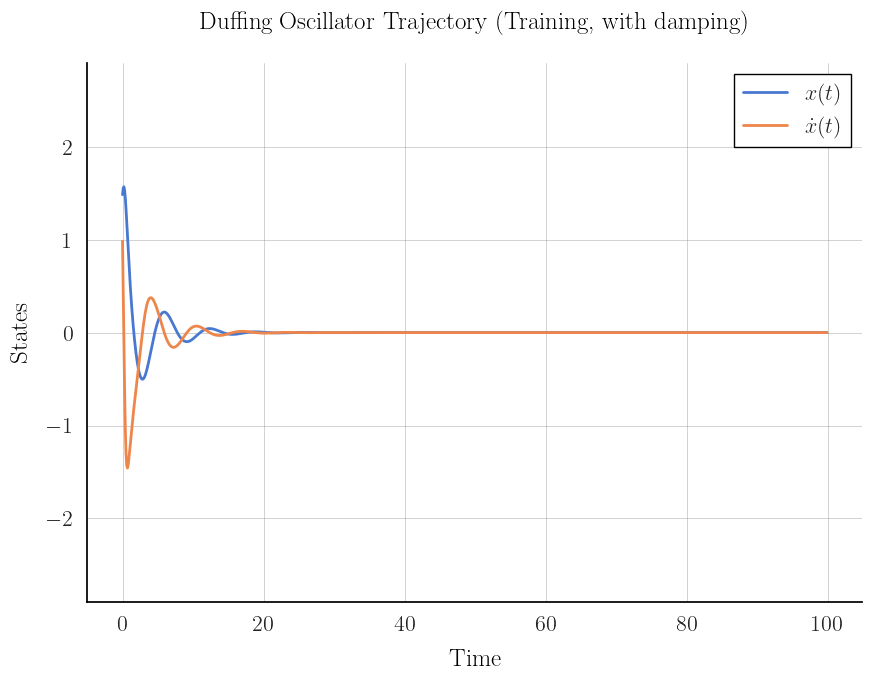

In [45]:
params = {
    'alpha': 1,   # Linear stiffness
    'beta': 1,     # Nonlinear stiffness
    'delta_1': 0.5,  # Linear damping 
    'delta_2': 0.5,  # Cubic damping 
}

# Generate training data (around [1.5, 0] initial condition)
t_conservation = 100.0 # energy is depleted by then

n_train = 20
std = 0.01
mean_ic = np.array([1.5, 1.0])
x_0 = np.random.randn(n_train, 2) * std + mean_ic
time_instances = np.arange(0, 100, 0.1)
x_train = []


for i in range(n_train):
    sol = odeint(duffing_oscillator, x_0[i, :], time_instances, args=(params, t_conservation))
    x_train.append(sol)

x_train = np.array(x_train)
x_train = [noisy_traj for noisy_traj in add_noise_with_snr(x_train, snr=500)]

model = ps.SINDy(feature_names=['x0', 'x1'],
                 feature_library=ps.PolynomialLibrary(degree=3),
                 optimizer=ps.STLSQ(threshold=5e-2))

model.fit(x_train, t=0.1, multiple_trajectories=True)
model.print()

# plot one trajectory from x_train
fig, ax = plotter.plot_trajectory(x_train[0], time_instances, title='Duffing Oscillator Trajectory (Training, with damping)', xlabel='Time', ylabel='States',
                                   state_names=["$x(t)$", "$\dot{x}(t)$"], ylim=(-2.9, 2.9), x_tick_skip=20)
# plt.savefig("/home/carlos/Downloads/duffing_training_with_damping.svg", bbox_inches='tight')
plt.show()

What if system suddenly becomes conservative? So the damping term $\delta$ goes to zero abruptly. We define the constraint object and set a very small noise (can you do the update at the same time?)

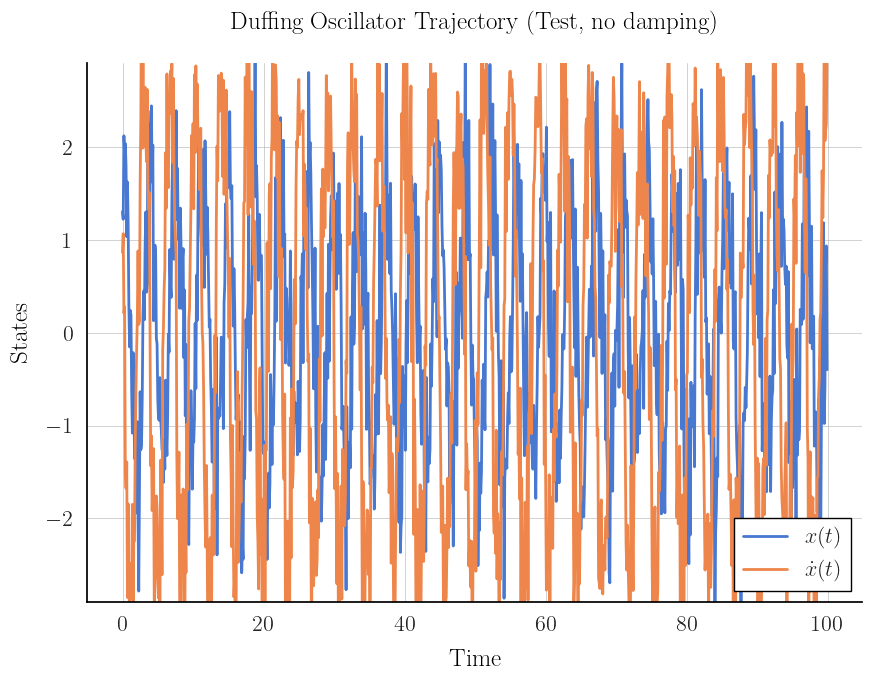

In [50]:
t_conservation = 0.0
time_instances = np.arange(0, 100, 0.1)
x_0_test = np.random.randn(1, 2) * std + mean_ic
x_test = odeint(duffing_oscillator, x_0_test[0, :], time_instances, args=(params, t_conservation))
x_test_noiseless = x_test.copy()
x_test = add_noise_with_snr(x_test, snr=8)

fig, ax = plotter.plot_trajectory(x_test, time_instances, x_tick_skip=20, title='Duffing Oscillator Trajectory (Test, no damping)', xlabel='Time', ylabel='States',
                                   state_names=["$x(t)$", "$\dot{x}(t)$"], ylim=(-2.9, 2.9))

# plt.savefig("/home/carlos/Downloads/duffing_test_no_damping.svg", bbox_inches='tight')
plt.show()

And now we setup the Kalman filter

library_terms: ['1', 'x0', 'x1', 'x0^2', 'x0 x1', 'x1^2', 'x0^3', 'x0^2 x1', 'x0 x1^2', 'x1^3']
alpha: 0.9989760833765027, beta: 0.9868430935432442


Processing: 100%|██████████| 999/999 [00:00<00:00, 3045.14it/s]


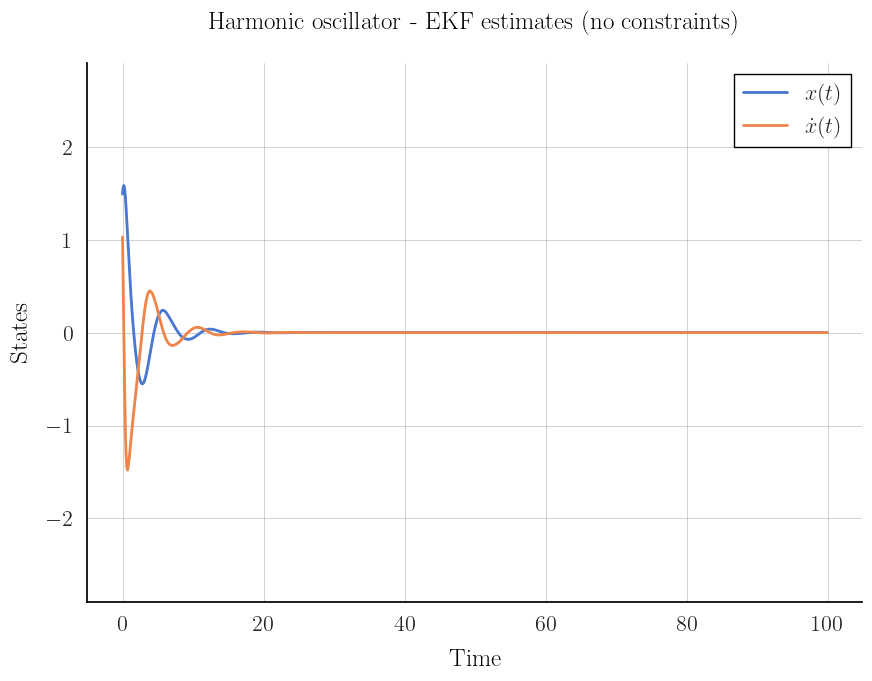

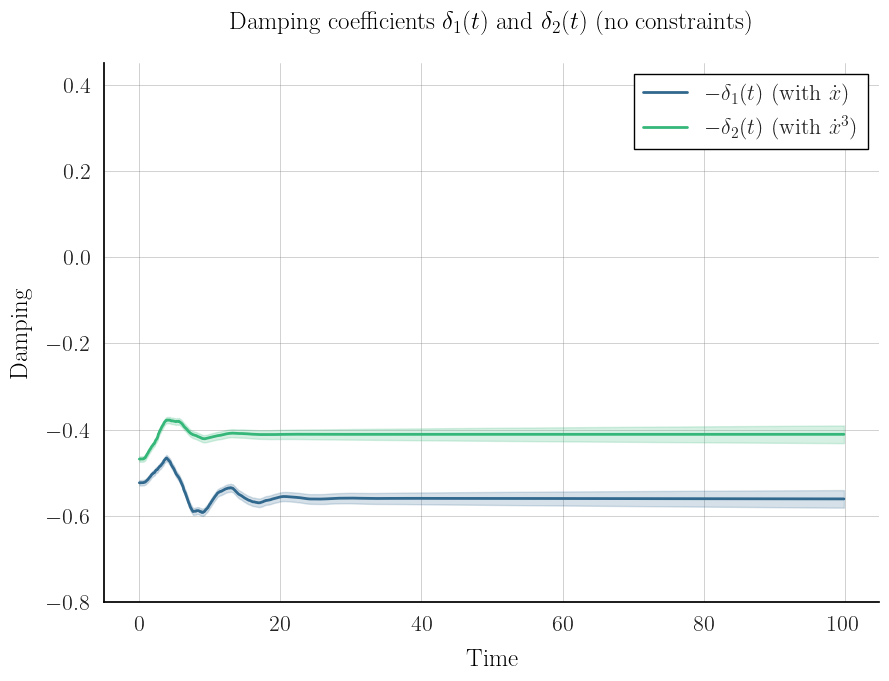

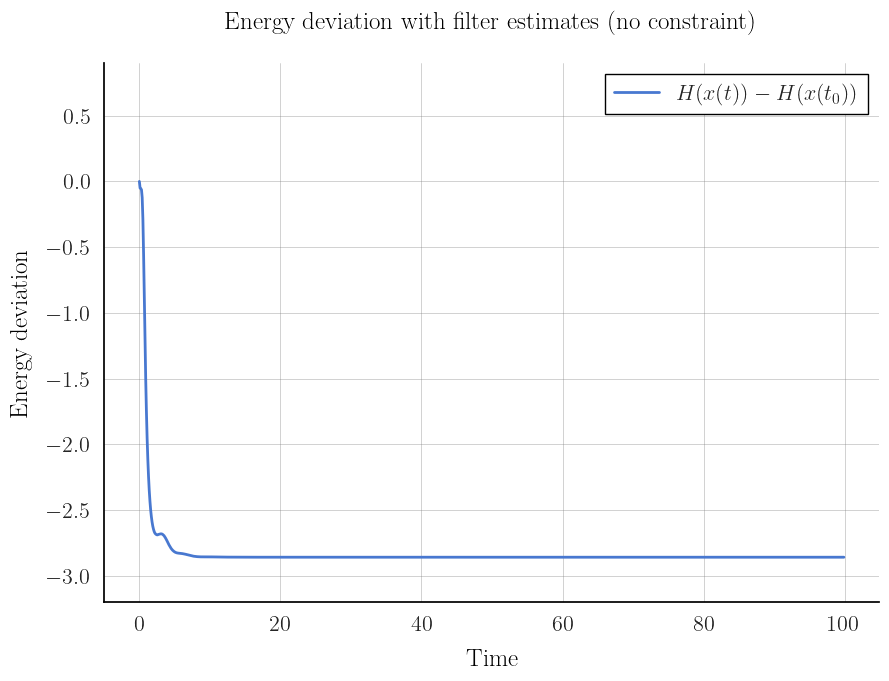

In [57]:
from ekf_vindy.plotting import plotter
from ekf_vindy.filters.ekf import EKF

# EKF configuration (linear and cubic damping have indices 2 and 3 in x_cal)
p0 = np.diag([1e-8, 1e-8, 1e-5, 1e-5]) # initial state covariance
q = np.diag([1e-8, 1e-8, 1e-6, 1e-6]) # process noise covariance
r = np.diag([4e-3, 4e-3])

library_terms = model.get_feature_names()
coeffs = model.coefficients()
variables = model.feature_names
print(f'library_terms: {library_terms}')

# correcting the sign for correct energy computation
# delta_1, delta_2 = -coeffs[1][2], -coeffs[1][9]
alpha, beta = -coeffs[1][1], -coeffs[1][6]
print(f'alpha: {alpha}, beta: {beta}')
tracked_terms = [[],
               [2, 9]]

x0 = x_0_test[0, :]
config = DynamicsConfig(variables, library_terms, tracked_terms, coeffs, q, r)
filter = EKF(x0, p0, config=config, integration_rule='RK4')

dts = np.diff(time_instances)
observations = x_test[1:, :]
filter.run_filter(dts, observations)

filter_estimates = filter.states.xcal_states[:, 0:2]
sdevs = filter.states.sdev_states[:, 0:2]

fig, x = plotter.plot_trajectory(filter_estimates, time_instances, sdevs, x_tick_skip=20, title='Harmonic oscillator - EKF estimates (no constraints)', xlabel='Time', ylabel='States', 
                                 state_names=["$x(t)$", "$\dot{x}(t)$"], ylim=(-2.9, 2.9))
# plt.savefig("/home/carlos/Downloads/duffing_no_constraint.svg", bbox_inches='tight')
plt.show()
damping_term = filter.states.xcal_states[:, [2, 3]]
damping_sdev = filter.states.sdev_states[:, [2, 3]]

fig, x = plotter.plot_trajectory(damping_term, time_instances, damping_sdev, x_tick_skip=20, title="Damping coefficients $\delta_1(t)$ and $\delta_2(t)$ (no constraints)", xlabel='Time', ylabel='Damping',
                                 state_names=["$-\delta_1 (t)$ (with $\dot{x}$)", "$-\delta_2 (t)$ (with $\dot{x}^3$)"], palette="viridis",
                                 ylim=(-0.8, 0.45))
# plt.savefig("/home/carlos/Downloads/duffing_damping_no_constraint.svg", bbox_inches='tight')
plt.show()
# compute energy
def compute_dE(x, x0):
     return np.array([energy(x, alpha, beta) - energy(x0, alpha, beta)])
delta_x0 = lambda x: compute_dE(x, x0)

# is energy conserved?
energy_diff = [delta_x0(xi) for xi in filter_estimates]
energy_diff = np.array(energy_diff)
fig, ax = plotter.plot_trajectory(energy_diff, time_instances, x_tick_skip=20, title='Energy deviation with filter estimates (no constraint)', xlabel='Time', ylabel='Energy deviation', 
                                  state_names=["$H(x(t)) - H(x(t_0))$"], ylim=(-3.2, 0.9))
# plt.savefig("/home/carlos/Downloads/duffing_energy_no_constraint.svg", bbox_inches='tight')
plt.show()



Now let's consider the energy conservation constraint (from $t=0$)

Processing: 100%|██████████| 999/999 [00:00<00:00, 1999.57it/s]


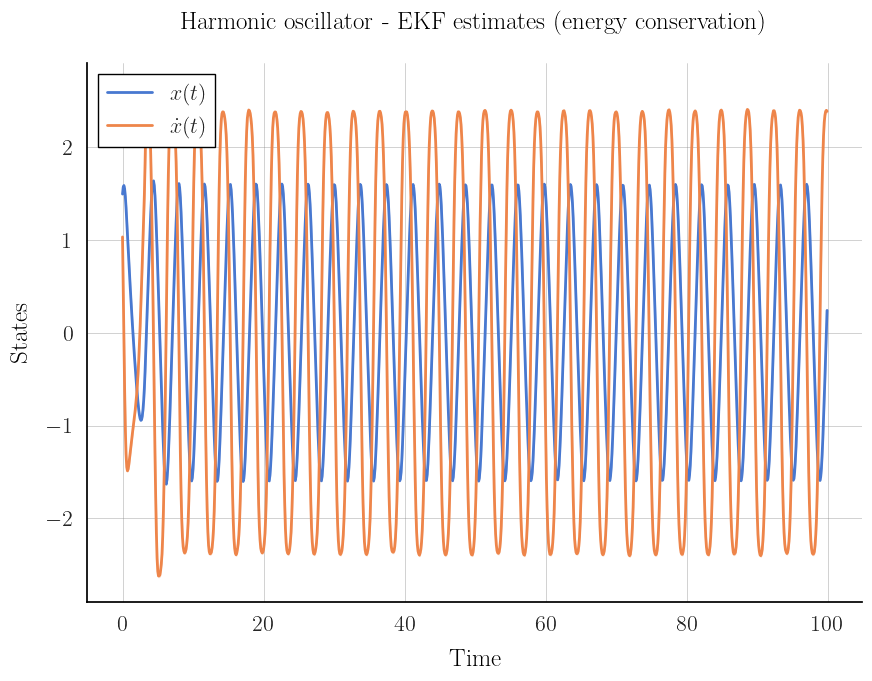

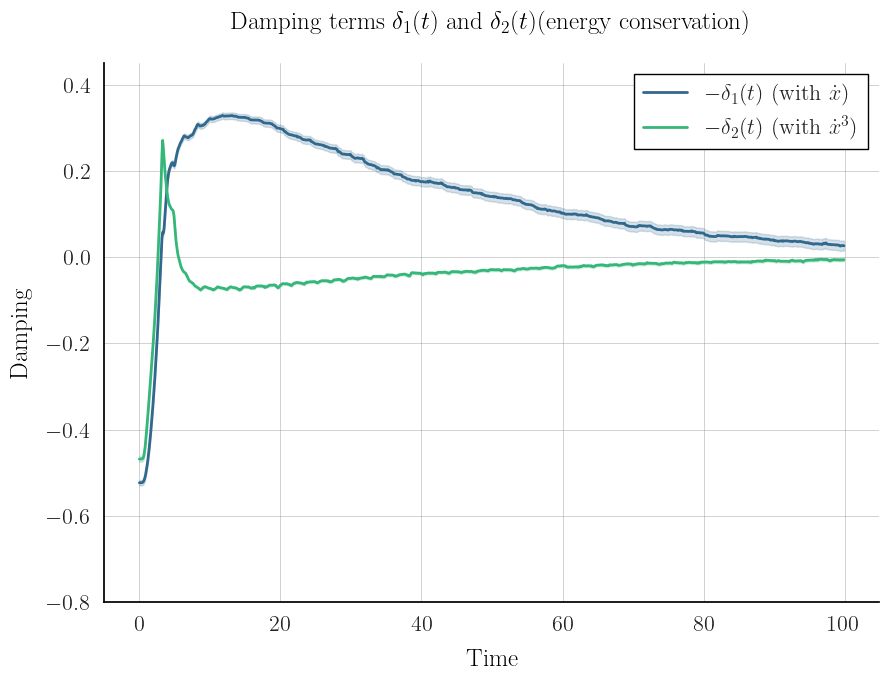

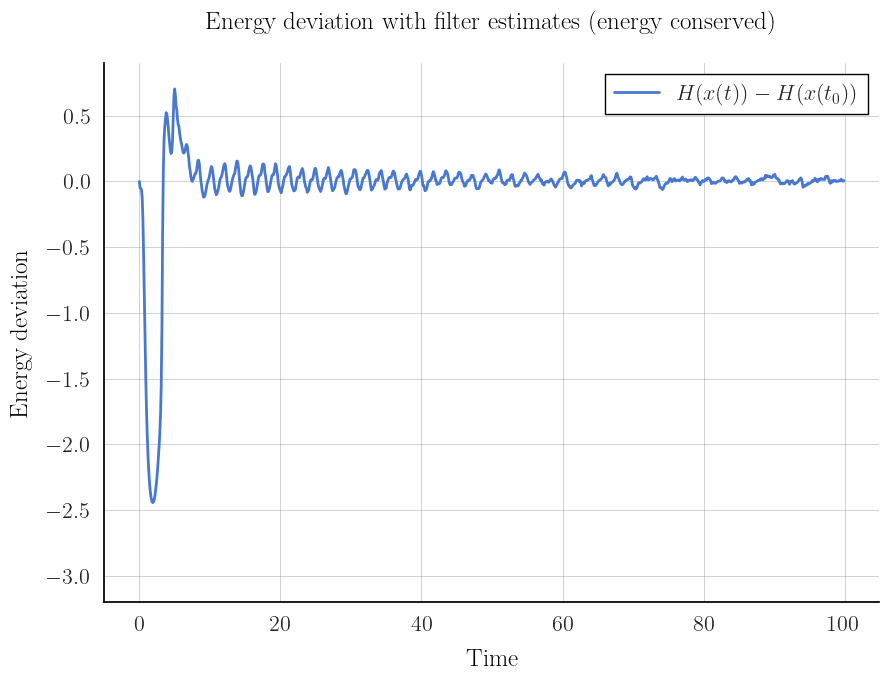

In [58]:
from ekf_vindy.plotting import plotter
from ekf_vindy.filters.ekf import EKF
from ekf_vindy.filters.constraints import ConservationDuffingCubic

constr_cov = np.diag([7e-4])

full_dimension = 2 + filter.n_tracked_terms
constraint = ConservationDuffingCubic(alpha, beta, constr_cov, x0, full_dimension)

filter = EKF(x0, p0, config=config, integration_rule='RK4')
filter.run_filter(dts, observations, constraint)

filter_estimates = filter.states.xcal_states[:, 0:2]
sdevs = filter.states.sdev_states[:, 0:2]
fig, x = plotter.plot_trajectory(filter_estimates, time_instances, sdevs, x_tick_skip=20, title='Harmonic oscillator - EKF estimates (energy conservation)', xlabel='Time', ylabel='States', 
                                 state_names=["$x(t)$", "$\dot{x}(t)$"], ylim=(-2.9, 2.9))
# plt.savefig("/home/carlos/Downloads/duffing_with_constraint.svg", bbox_inches='tight')
plt.show()

damping_term = filter.states.xcal_states[:, [2, 3]]
damping_sdev = filter.states.sdev_states[:, [2, 3]]

fig, x = plotter.plot_trajectory(damping_term, time_instances, damping_sdev, x_tick_skip=20, title="Damping terms $\delta_1(t)$ and $\delta_2(t)$(energy conservation)", xlabel='Time', ylabel='Damping',
                                 state_names=["$-\delta_1 (t)$ (with $\dot{x}$)", "$-\delta_2 (t)$ (with $\dot{x}^3$)"], palette="viridis",
                                 ylim=(-0.8, 0.45))
# plt.savefig("/home/carlos/Downloads/duffing_damping_with_constraint.svg", bbox_inches='tight')
plt.show()

# is energy conserved?
energy_diff = [delta_x0(xi) for xi in filter_estimates]
energy_diff = np.array(energy_diff)
fig, ax = plotter.plot_trajectory(energy_diff, time_instances, x_tick_skip=20, title='Energy deviation with filter estimates (energy conserved)', xlabel='Time', ylabel='Energy deviation', 
                                  state_names=["$H(x(t)) - H(x(t_0))$"], ylim=(-3.2, 0.9))
# plt.savefig("/home/carlos/Downloads/duffing_energy_with_constraint.svg", bbox_inches='tight')
plt.show()




(<Figure size 1000x700 with 1 Axes>,
 <Axes: title={'center': '\\textrm{Duffing Oscillator Test Trajectory (Noiseless)}'}, xlabel='\\textrm{Time}', ylabel='\\textrm{States}'>)

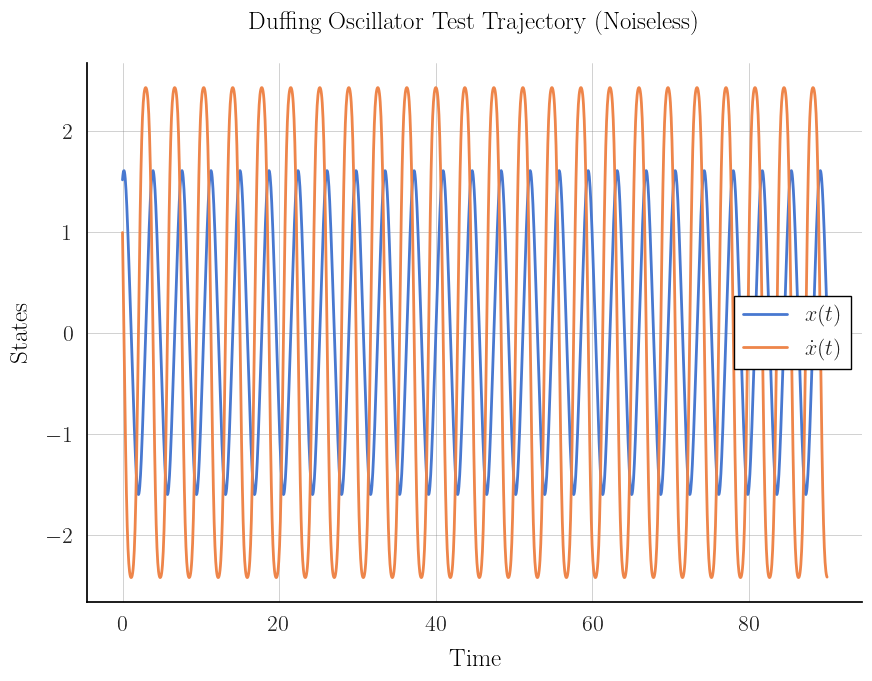

In [159]:
# noiseless observations

plotter.plot_trajectory(x_test_noiseless, time_instances, x_tick_skip=20, title='Duffing Oscillator Test Trajectory (Noiseless)', xlabel='Time', ylabel='States',
                                      state_names=["$x(t)$", "$\dot{x}(t)$"])